# Machine Learning–Driven Salary Inequality & Pay Equity Analysis System

**Name:** CH Srivathsavi  
**Email ID:** chsrivathsavi07@gmail.com  

---

##  Project Description

Developed an end-to-end machine learning–based HR analytics system to predict fair employee salaries using role, grade, and organizational attributes.  
The project identifies underpaid and overpaid employees through pay gap and anomaly detection, highlights potential bias, and provides explainable salary correction recommendations.  
This solution supports ethical, data-driven compensation decisions and reduces organizational pay-equity risks.


## STEP 1: Install & Import Libraries

In [3]:
pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Import Libraries 

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## STEP 2: Load Dataset

In [5]:
df = pd.read_csv("ibm_hr_compensation_payroll_data.csv")
df.head()


,MANDT,PERNR,SUBTY,OBJPS,SPRPS,ENDDA,BEGDA,SEQNR,AEDTM,UNAME,...,PAYROLL_RELATIONSHIP_ID,BALANCE_TYPE_ID,BALANCE_DIMENSION_ID,ELEMENT_TYPE_ID,INPUT_VALUE_ID,PROCESSING_TYPE,PRIORITY,CLASSIFICATION_ID,COST_TYPE,ACTIVITY_TYPE
0,100,1,0,1,,20261231,20200106,0,20260114,HR_ADMIN,...,8001,9001,9101,9201,9301,B,8736,9401,C,PAYROLL_RUN
1,100,2,0,1,,20261231,20150925,0,20250710,HR_ADMIN,...,8002,9002,9102,9202,9302,A,9416,9402,C,PAYROLL_RUN
2,100,3,0,1,,20261231,20200327,0,20260518,HR_ADMIN,...,8003,9003,9103,9203,9303,A,4543,9403,C,PAYROLL_RUN
3,100,4,0,1,,20261231,20150128,0,20240923,HR_ADMIN,...,8004,9004,9104,9204,9304,A,3784,9404,D,PAYROLL_RUN
4,100,5,0,1,,20261231,20210118,0,20261122,HR_ADMIN,...,8005,9005,9105,9205,9305,B,8010,9405,C,PAYROLL_RUN


## STEP 3: Select Relevant Columns (Problem-Focused)

In [6]:
df = df[[
    "PERNR",
    "ANSAL",
    "BSGRD",
    "TRFGR",
    "TRFST",
    "ORZID",
    "WAERS",
    "PAYROLL_PERIOD"
]]


## STEP 4: Data Cleaning

In [7]:
# Remove invalid salaries

df = df[df["ANSAL"] > 0]
df.dropna(inplace=True)

## STEP 5: Currency Normalization

In [8]:
currency_rates = {
    "USD": 1.0,
    "EUR": 1.1,
    "INR": 0.012
}

df["SALARY_USD"] = df.apply(
    lambda x: x["ANSAL"] * currency_rates.get(x["WAERS"], 1.0),
    axis=1
)


## STEP 6: Gender Simulation for Bias Detection

In [9]:
# Ethical simulation — no real personal data

np.random.seed(42)
df["GENDER"] = np.random.choice(["Male", "Female"], size=len(df), p=[0.6, 0.4])


## STEP 7: Feature Encoding

In [10]:
label_cols = ["TRFGR", "TRFST", "ORZID"]

encoder = LabelEncoder()
for col in label_cols:
    df[col] = encoder.fit_transform(df[col])


## STEP 8: Feature & Target Definition

In [11]:
X = df[["BSGRD", "TRFGR", "TRFST", "ORZID"]]
y = df["SALARY_USD"]


## STEP 9: Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## STEP 10: Train ML Model (Random Forest)

In [13]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

## STEP 11: Model Evaluation

In [14]:
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 71822.17591229423
RMSE: 83104.72704242238
R2 Score: -0.0006314092599535304


## STEP 12: Predict Fair Salary

In [15]:
df["PREDICTED_SALARY"] = model.predict(X)


## STEP 13: Pay Gap Calculation

In [16]:
df["PAY_GAP"] = df["SALARY_USD"] - df["PREDICTED_SALARY"]

df["PAY_GAP_PERCENT"] = (
    df["PAY_GAP"] / df["PREDICTED_SALARY"]
) * 100


## STEP 14: Pay Inequality Classification

In [17]:
def classify_gap(x):
    if x < -15:
        return "UNDERPAID"
    elif x > 15:
        return "OVERPAID"
    else:
        return "FAIR"

df["PAY_STATUS"] = df["PAY_GAP_PERCENT"].apply(classify_gap)


## STEP 15: Anomaly Detection – Isolation Forest

In [18]:
iso = IsolationForest(contamination=0.05, random_state=42)

df["OUTLIER"] = iso.fit_predict(
    df[["SALARY_USD", "PREDICTED_SALARY"]].values
)

df["OUTLIER"] = df["OUTLIER"].map({-1: "YES", 1: "NO"})


## STEP 16: Gender Pay Gap Analysis

In [19]:
gender_gap = df.groupby("GENDER")["SALARY_USD"].mean()
gender_gap


GENDER
Female    122675.155798
Male      129331.460875
Name: SALARY_USD, dtype: float64

In [20]:
gender_gap_percent = (
    (gender_gap["Male"] - gender_gap["Female"]) /
    gender_gap["Male"]
) * 100

gender_gap_percent


5.146702149744954

## STEP 17: Salary Recommendation Engine

In [21]:
def salary_recommendation(row):
    if row["PAY_STATUS"] == "UNDERPAID":
        return f"Increase salary by {abs(row['PAY_GAP_PERCENT']):.1f}%"
    elif row["PAY_STATUS"] == "OVERPAID":
        return "Review compensation"
    else:
        return "No action required"

df["RECOMMENDATION"] = df.apply(salary_recommendation, axis=1)


## STEP 18: Time-Based Salary Growth Analysis

In [22]:
df["YEAR"] = df["PAYROLL_PERIOD"].astype(str).str[:4]

salary_trend = df.groupby("YEAR")["SALARY_USD"].mean()
salary_trend


YEAR
2024    126611.250867
Name: SALARY_USD, dtype: float64

## STEP 19: Visualization

### Actual vs Predicted Salary

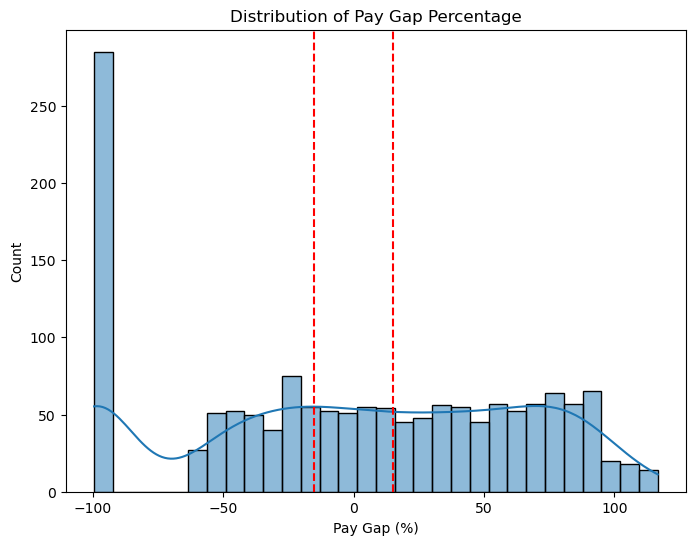

In [37]:
plt.figure(figsize=(8,6))
sns.histplot(
    df["PAY_GAP_PERCENT"],
    bins=30,
    kde=True
)
plt.axvline(-15, color="red", linestyle="--")
plt.axvline(15, color="red", linestyle="--")
plt.title("Distribution of Pay Gap Percentage")
plt.xlabel("Pay Gap (%)")
plt.show()


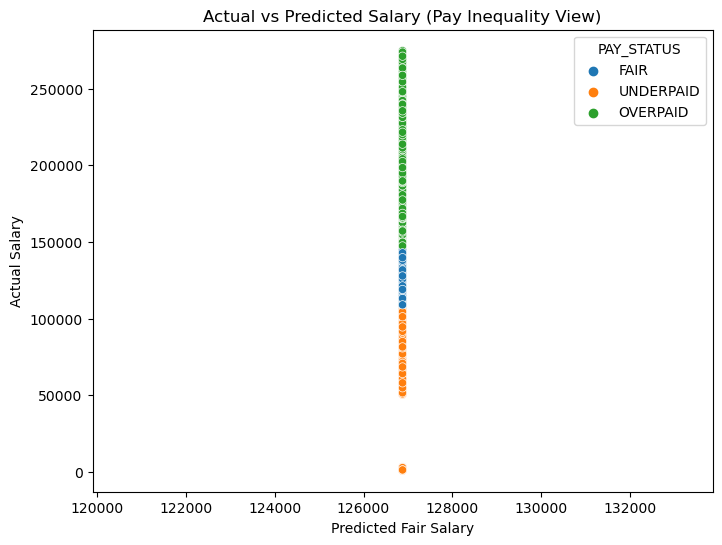

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PREDICTED_SALARY",
    y="SALARY_USD",
    hue="PAY_STATUS",
    data=df
)
plt.plot(
    [df["PREDICTED_SALARY"].min(), df["PREDICTED_SALARY"].max()],
    [df["PREDICTED_SALARY"].min(), df["PREDICTED_SALARY"].max()],
    'r--'
)
plt.xlabel("Predicted Fair Salary")
plt.ylabel("Actual Salary")
plt.title("Actual vs Predicted Salary (Pay Inequality View)")
plt.show()


### Salary Distribution by Pay Status

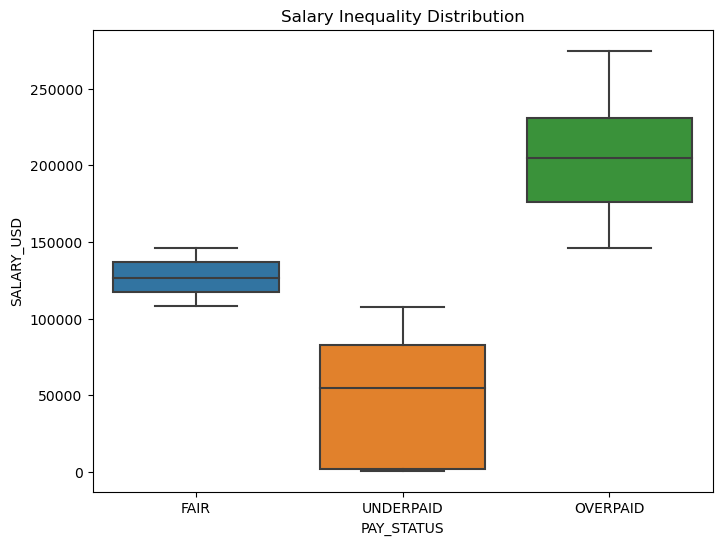

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(x="PAY_STATUS", y="SALARY_USD", data=df)
plt.title("Salary Inequality Distribution")
plt.show()


## STEP 20: Save Final Results

In [26]:
df.to_csv("salary_inequality_final_results.csv", index=False)


In [27]:
def explain_employee_salary(employee_id, df):
    employee_id = str(employee_id).strip().zfill(8)
    df["PERNR"] = df["PERNR"].astype(str).str.strip().str.zfill(8)

    emp = df[df["PERNR"] == employee_id]

    if emp.empty:
        print(f"❌ Employee ID {employee_id} not found.")
        print("Sample valid IDs:", df["PERNR"].head(5).tolist())
        return

    emp = emp.iloc[0]

    print("\n================ SALARY FAIRNESS REPORT ================\n")
    print(f"Employee ID        : {emp['PERNR']}")
    print(f"Gender             : {emp['GENDER']}")
    print(f"Department (ORZID) : {emp['ORZID']}")
    print(f"Grade (BSGRD)      : {emp['BSGRD']}")
    print(f"Role Group (TRFGR) : {emp['TRFGR']}")
    print(f"Role Level (TRFST) : {emp['TRFST']}")
    print(f"Year               : {emp['YEAR']}")

    print("\n---------------- SALARY DETAILS ----------------")
    print(f"Actual Salary (USD)    : ${emp['SALARY_USD']:,.2f}")
    print(f"Predicted Fair Salary  : ${emp['PREDICTED_SALARY']:,.2f}")

    print("\n---------------- PAY GAP ANALYSIS ----------------")
    print(f"Pay Gap Percentage     : {emp['PAY_GAP_PERCENT']:.2f}%")
    print(f"Pay Status             : {emp['PAY_STATUS']}")

    print("\n---------------- ANOMALY CHECK ----------------")
    print(f"Outlier Detected       : {emp['OUTLIER']}")

    print("\n---------------- RECOMMENDATION ----------------")
    print(f"HR Recommendation      : {emp['RECOMMENDATION']}")
    print("\n=======================================================\n")


In [29]:
df[["PERNR"]].head(5)


,PERNR
0,00000001
1,00000002
2,00000003
3,00000004
4,00000005


In [30]:
df["PERNR"] = df["PERNR"].astype(str).str.strip().str.zfill(8)


In [31]:
df["PERNR"].head(5)


0    00000001
1    00000002
2    00000003
3    00000004
4    00000005
Name: PERNR, dtype: object

In [32]:
df["PERNR"].sample(5)


1481    00001482
1115    00001116
1066    00001067
773     00000774
1170    00001171
Name: PERNR, dtype: object

In [40]:
emp_id = df["PERNR"].iloc[0]
print(emp_id)
explain_employee_salary(emp_id, df)


00000001

================ SALARY FAIRNESS REPORT ================

Employee ID        : 00000001
Gender             : Male
Department (ORZID) : 0
Grade (BSGRD)      : 1.0
Role Group (TRFGR) : 0
Role Level (TRFST) : 0
Year               : 2024

---------------- SALARY DETAILS ----------------
Actual Salary (USD)    : $122,057.10
Predicted Fair Salary  : $126,878.32

---------------- PAY GAP ANALYSIS ----------------
Pay Gap Percentage     : -3.80%
Pay Status             : FAIR

---------------- ANOMALY CHECK ----------------
Outlier Detected       : NO

---------------- RECOMMENDATION ----------------
HR Recommendation      : No action required




In [41]:
emp_id = input("Enter Employee ID: ")
explain_employee_salary(emp_id, df)

Enter Employee ID: 00003

================ SALARY FAIRNESS REPORT ================

Employee ID        : 00000003
Gender             : Female
Department (ORZID) : 0
Grade (BSGRD)      : 1.0
Role Group (TRFGR) : 0
Role Level (TRFST) : 0
Year               : 2024

---------------- SALARY DETAILS ----------------
Actual Salary (USD)    : $94,233.00
Predicted Fair Salary  : $126,878.32

---------------- PAY GAP ANALYSIS ----------------
Pay Gap Percentage     : -25.73%
Pay Status             : UNDERPAID

---------------- ANOMALY CHECK ----------------
Outlier Detected       : NO

---------------- RECOMMENDATION ----------------
HR Recommendation      : Increase salary by 25.7%


